In [1]:
import numpy as np
from scene import Scene
from matplotlib import pyplot as plt
%matplotlib inline

## Load data

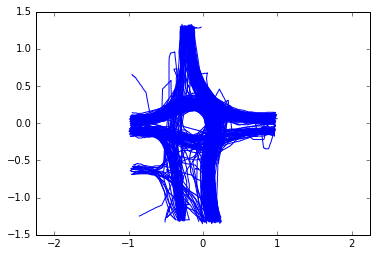

In [50]:
from process_data import get_trajectories, prune
x_data, y_data, V_scale = get_trajectories('../annotations/deathCircle/video3/', label='Biker')
curves = [ np.vstack([x,y]) for (x,y) in zip(x_data,y_data)]

for x,y in zip(x_data, y_data):
    plt.plot(x,y,'b-')
plt.axis('equal')
plt.show()

## Prune data

In [51]:
from cluster import prune_cluster
n_discarded, curves_pruned = prune_cluster( curves )

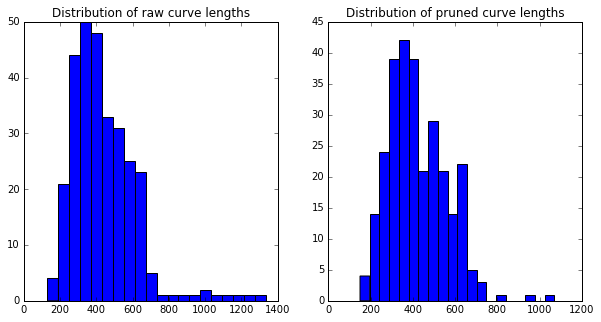

In [52]:
fig, ax_arr = plt.subplots(1,2, figsize=(10,5))
ax_arr[0].hist( map(len,x_data), bins=20)
ax_arr[0].set_title("Distribution of raw curve lengths")
ax_arr[1].hist( map( lambda x: x.shape[1], curves_pruned), bins=20)
ax_arr[1].set_title("Distribution of pruned curve lengths")

## Generate train-test split

In [53]:
from sklearn.cross_validation import KFold, train_test_split
n = len(curves_pruned)
n_folds = 5
#kf = KFold(n, n_folds=n_folds, random_state = 42)
#for train, test in kf:
#    print "train = " + str(train)
#    print "test  = " + str(test)

In [54]:
train, test = train_test_split( curves_pruned, random_state = 42)

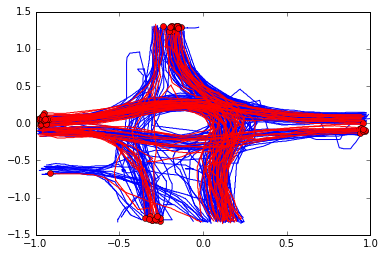

In [55]:
for c in train:
    plt.plot( c[0], c[1], 'b-')
    
for c in test:
    plt.plot(c[0], c[1], 'r-')
    plt.plot(c[0,0], c[1,0], 'ro')

## Train, predict, measure error

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.


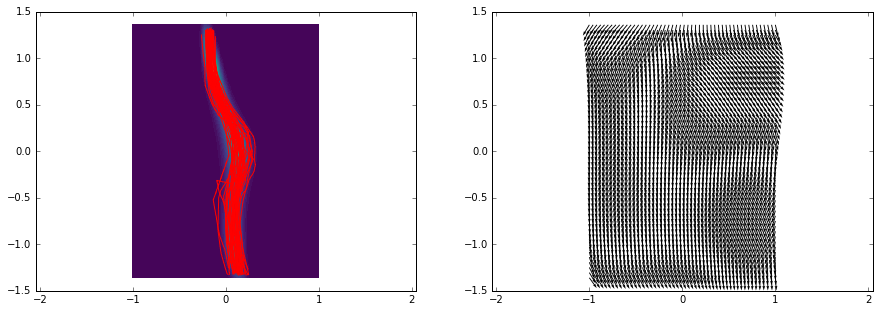

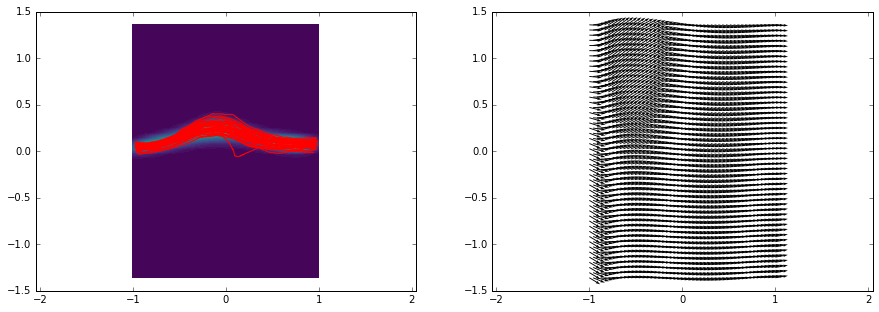

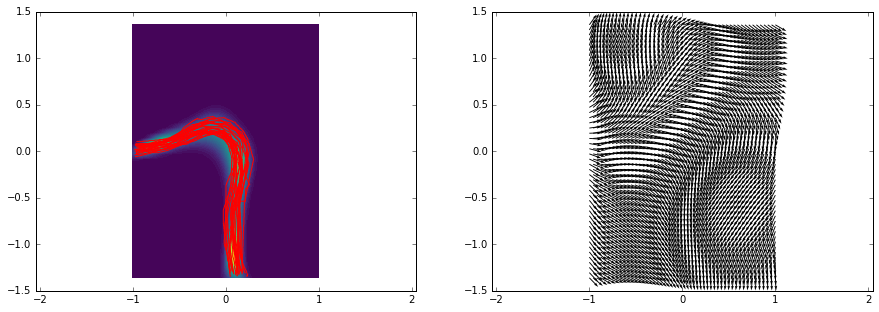

In [56]:
#help(Scene)
scene = Scene( train, V_scale, k_max_theta=15, k_max_vf=15 )

for k in range(scene.num_nl_classes):
    from visualization_routines import visualize_cluster
    visualize_cluster( scene, k)

In [57]:
t0 = 2
subj = 0
mu = test[subj][:,t0]
eta = ( test[subj][:,t0+2] - test[subj][:,t0-2] ) / float(4)
scene.set_mu( mu )
scene.set_eta( eta )

In [58]:
x_span = np.linspace( -V_scale[0], V_scale[0], 50 )
y_span = np.linspace( -V_scale[1], V_scale[1], 50 )
X_grid, Y_grid = np.meshgrid( x_span, y_span)

P_c = 0.000000
Skipping computation for class c_0.  P(c_0 | mu )=2.92282e-07 < 0.001 

P_c = 0.866117
c_1 case computed.

P_c = 0.471858
c_2 case computed.

P_linear = -0.337976


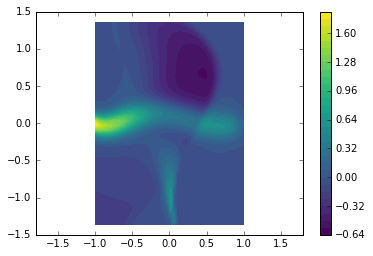

In [67]:
T=20
rho = scene.predict_pdf( X_grid, Y_grid, T)
cs = plt.contourf( X_grid, Y_grid, rho, 30, cmap = 'viridis')
plt.axis('equal')
cb = plt.colorbar( cs)

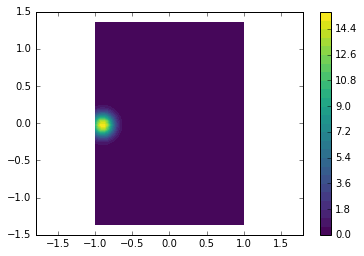

In [63]:
mu_T = test[subj][:,T]
eta_T = ( test[subj][:,T+2] - test[subj][:,T-2] ) / float(4)
scene.set_mu( mu_T )
scene.set_eta( eta_T )
rho_obs = scene.P_of_x_given_mu( np.vstack( [X_grid.flatten(), Y_grid.flatten() ])).reshape( X_grid.shape)
cs = plt.contourf( X_grid, Y_grid, rho_obs, 30, cmap = 'viridis')
plt.axis('equal')
cb = plt.colorbar(cs)

In [64]:
err = (np.abs( rho_obs-rho )).mean() / (V_scale[0]*V_scale[1])
L1_rho = (np.abs( rho )).mean() / (V_scale[0]*V_scale[1])
L1_rho_obs = (np.abs( rho_obs )).mean() / (V_scale[0]*V_scale[1])

In [65]:
print "error     = %g" % err
print "|rho|     = %g" % L1_rho
print "|rho_obs| = %g" % L1_rho_obs

error     = 0.127963
|rho|     = 0.0643426
|rho_obs| = 0.115717


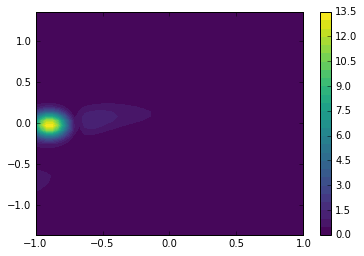

In [66]:
cs = plt.contourf( X_grid, Y_grid, np.abs(rho-rho_obs), 30, cmap= 'viridis')
cb = plt.colorbar(cs)